In [2]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [3]:
file_path = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp'
#file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
file_path = '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp'
diagType = 'ocean_annual_z'

years = ['0521-0525','0526-0530']

In [4]:
plot_out='../plots/esm41piC_0531-0550_'

#plot_out='../plots_esm42/052422/esm42_prev_0546-0550'
plot_out='../plots_esm42/060922/esm42_dev_060922_'

In [5]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
thetao_var = 'thetao'
thetao_file_prefix = os.path.join(file_path, diagType, 'ts', 'annual', '5yr/')
thetao_files = [dot.join([thetao_file_prefix + diagType, yy, thetao_var, 'nc']) for yy in years]
print(thetao_files)

so_var = 'so'
so_file_prefix = os.path.join(file_path, diagType, 'ts', 'annual', '5yr/')
so_files = [dot.join([so_file_prefix + diagType, yy, so_var, 'nc']) for yy in years]
print(so_files)

['/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0521-0525.thetao.nc', '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0526-0530.thetao.nc']
['/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0521-0525.so.nc', '/archive/Jessica.Luo/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond_upSoilC_COBALTmods_060922/gfdl.ncrc4-intel19-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0526-0530.so.nc']


In [6]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

## Temperature

In [7]:
# Model
ds_thetao = xr.open_mfdataset(thetao_files, combine='by_coords')
ds_thetao = ds_thetao.sel(z_l=2.5)

In [8]:
# Observations
# WOA18
temp_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/temp_woa18_esm4grid.nc'
temp_obs = xr.open_dataset(temp_obs_file)
temp_obs = temp_obs.sel(z_l=2.5)
temp_obs

<xarray.Dataset>
Dimensions:     (xh: 720, yh: 576)
Coordinates:
    z_l         float64 2.5
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
Data variables:
    temp_woa18  (yh, xh) float64 ...

## Surface salinity

In [9]:
# Model
ds_so = xr.open_mfdataset(so_files, combine='by_coords')
ds_so = ds_so.sel(z_l=2.5)

In [10]:
# Observations
# Salinity data, remapped from GLODAP 
# units are micromoles per kg, convert to mmoles m^3 using 1035/1000
salt_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/Salt_glodap_esm4grid.nc'
salt_obs = xr.open_dataset(salt_obs_file)
salt_obs = salt_obs.sel(z_l=2.5)
salt_obs

<xarray.Dataset>
Dimensions:      (xh: 720, yh: 576)
Coordinates:
    z_l          float64 2.5
  * yh           (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * xh           (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
Data variables:
    Salt_glodap  (yh, xh) float64 ...

# Evaluate Skill Metrics

In [11]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [12]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [13]:
X=ds_so.so.mean(dim='time').stack(z=('xh','yh')).values
Y=salt_obs.Salt_glodap.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_salt = X[mask] - Y[mask]
res2_salt = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_salt = stats.skew(res1_salt)
skew2_salt = stats.skew(res2_salt)
res_salt = res1_salt
r_salt = stats.pearsonr(X[mask],Y[mask])[0]
rmse_salt = rmse_diffs(res_salt)
bias_salt = np.mean(res_salt)

In [14]:
X=ds_thetao.thetao.mean(dim='time').stack(z=('xh','yh')).values
Y=temp_obs.temp_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_temp = X[mask] - Y[mask]
res2_temp = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_temp = stats.skew(res1_temp)
skew2_temp = stats.skew(res2_temp)
res_temp = res1_temp
r_temp = stats.pearsonr(X[mask],Y[mask])[0]
rmse_temp = rmse_diffs(res_temp)
bias_temp = np.mean(res_temp)

# Plot 

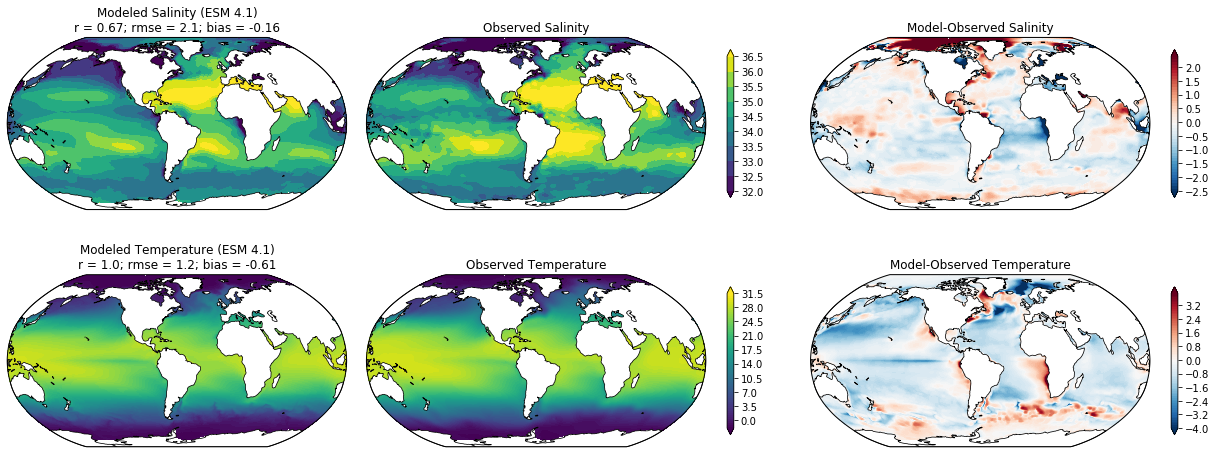

In [15]:
fig=plt.figure(figsize=(22,8))
gs=gridspec.GridSpec(2,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Salinity                                                              #
###########################################################################

cmin = 32; cmax = 37; cint = 0.5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_so.so.mean(dim='time')
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled Salinity (ESM 4.1)\nr = ' + str(np.round(r_salt,2)) + \
                 '; rmse = ' + str(np.round(rmse_salt,1)) + \
                 '; bias = ' + str(np.round(bias_salt,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=salt_obs.Salt_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Salinity', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)

i=2
ax[i]=plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-2.5,2.5,.1), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed Salinity', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)


###########################################################################
# Temperature                                                             #
###########################################################################

cmin = -2; cmax = 32; cint = 0.5
levels=np.arange(cmin,cmax,cint)

i=3
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_thetao.thetao.mean(dim='time')
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled Temperature (ESM 4.1)\nr = ' + str(np.round(r_temp,2)) + \
                 '; rmse = ' + str(np.round(rmse_temp,1)) + \
                 '; bias = ' + str(np.round(bias_temp,2)), fontsize=fs)

i=4
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=temp_obs.temp_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Temperature', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)

i=5
ax[i]=plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-4,4,.1), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed Temperature', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)


plt.tight_layout()
fname = 'sfc_temp_salinity_biases'
plt.savefig(plot_out+fname+'.png', dpi=300, bbox_inches='tight')